# Onset Detection

In [11]:
import numpy as np
import scipy
import librosa

In [12]:
### https://freesound.org/people/dr_skitz/sounds/353853/#
!gdown 1A0xYcASFyThjH869EEExnjg4hp58e26G

Downloading...
From: https://drive.google.com/uc?id=1A0xYcASFyThjH869EEExnjg4hp58e26G
To: /content/drum.wav
100% 772k/772k [00:00<00:00, 136MB/s]


In [13]:
audio, sr = librosa.load('drum.wav')

In [14]:
from IPython.display import Audio

Audio(data=audio, rate=sr)

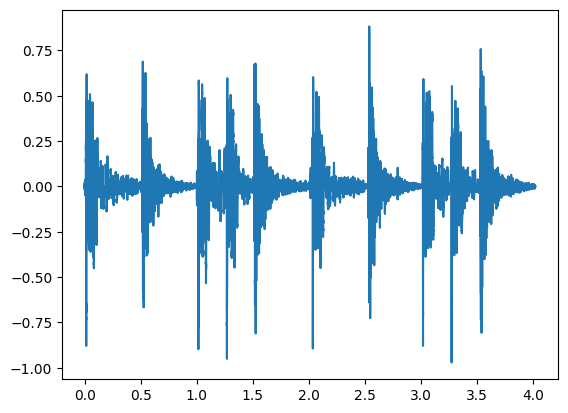

In [15]:
import matplotlib.pyplot as plt

t = np.arange(len(audio)) / sr
plt.plot(t, audio)

## Energy Based Novelty

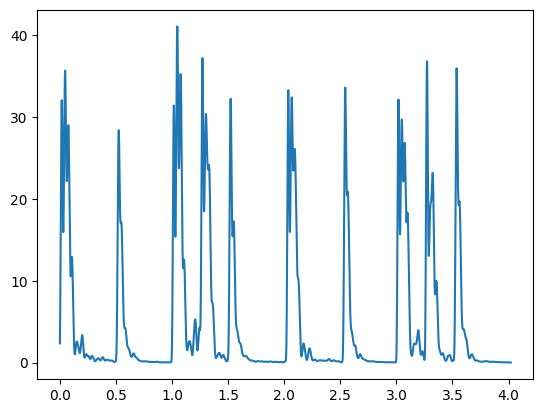

In [16]:
### compute local energy function
M = 512
w = scipy.signal.get_window('hann', 2*M+1)

def compute_local_energy(x, w, M):
    L = len(x)
    local_energy = np.zeros(L)
    for n in range(L):
        a = max(n - M, 0)
        b = min(n + M + 1, L)
        w_n = w[len(w)-(b-a):] if b < L else w[:(b-a)]
        local_energy[n] = np.sum((x[a:b]*w_n)**2)
    return local_energy

local_energy = compute_local_energy(audio, w, M)

plt.plot(t, local_energy)

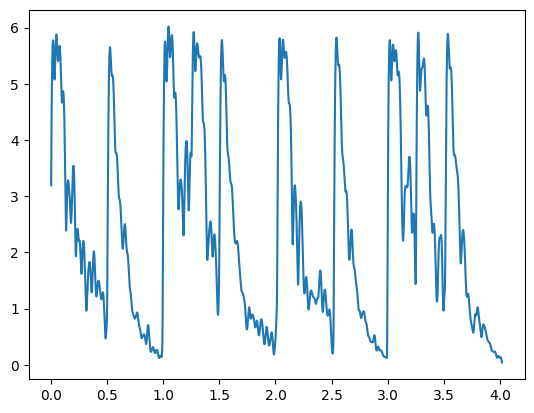

In [17]:
### apply logarithmic compression
gamma = 10
local_energy = np.log(1 + gamma*local_energy)

plt.plot(t, local_energy)

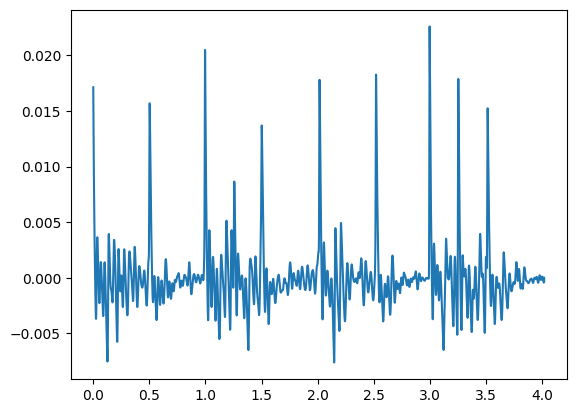

In [18]:
### compute local energy derivative
local_energy_diff = np.diff(local_energy)
local_energy_diff = np.concatenate([local_energy_diff, np.zeros(1)])

plt.plot(t, local_energy_diff)

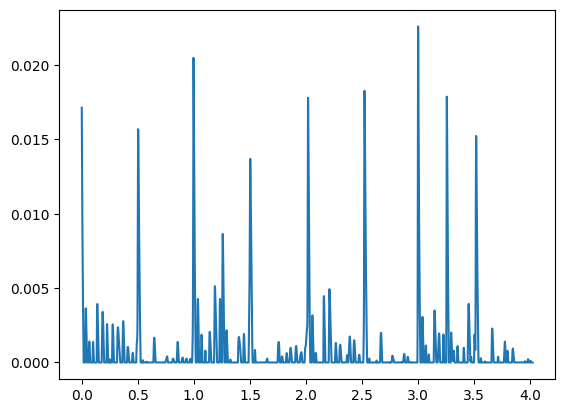

In [19]:
### apply half wave rectification
novelty_energy = np.copy(local_energy_diff)
novelty_energy[local_energy_diff < 0] = 0

plt.plot(t, novelty_energy)

## Spectral Based Novelty

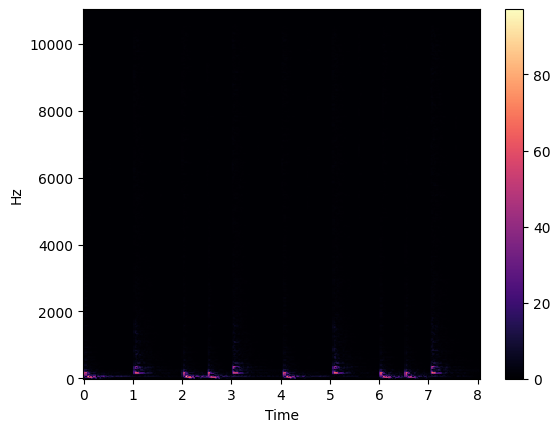

In [20]:
### compute magnitude spectrum
N_f = 1024
N_h = 256

X = librosa.stft(audio, n_fft=N_f, hop_length=N_h, window='hann')
Y = np.abs(X)

fig = plt.figure()
img = librosa.display.specshow(Y, y_axis='linear', x_axis='time')
fig.colorbar(img)

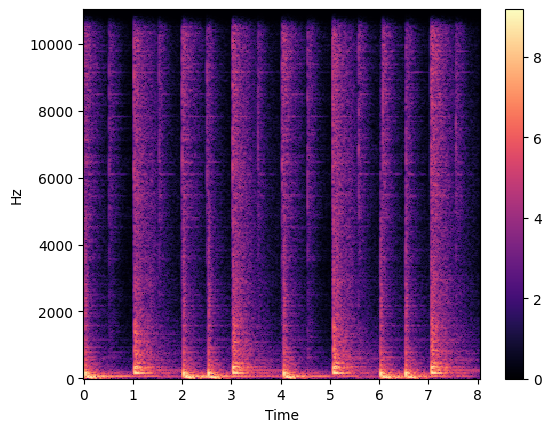

In [21]:
### apply logarithmic compression
gamma = 100
Y = np.log(1 + gamma*Y)

fig = plt.figure()
img = librosa.display.specshow(Y, y_axis='linear', x_axis='time')
fig.colorbar(img)

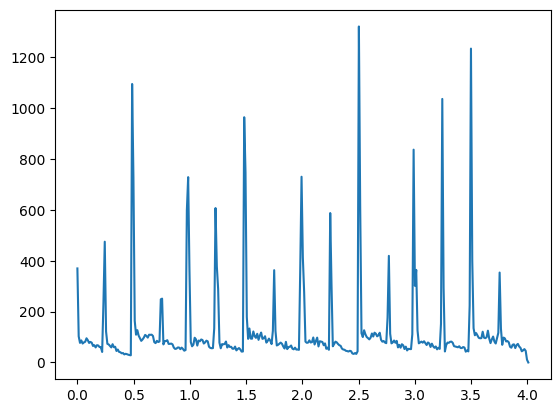

In [22]:
### compute discrete temporal derivative
energy_diff = np.diff(Y, n=1)
energy_diff[energy_diff < 0] = 0
energy_diff = np.sum(energy_diff, axis=0)
novelty_energy = np.concatenate([energy_diff, np.zeros(1)])

t_spec = np.linspace(0, len(audio)/sr, len(novelty_energy), endpoint=False)
plt.plot(t_spec, novelty_energy)

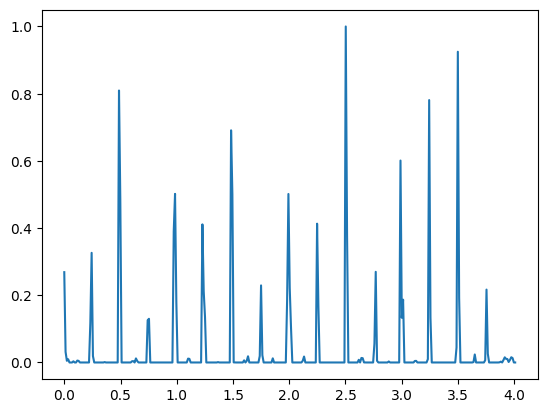

In [23]:
### apply normalization by subtracting local average
def compute_local_average(x, M):
    L = len(x)
    local_average = np.zeros(L)
    for m in range(L):
        a = max(m - M, 0)
        b = min(m + M + 1, L)
        local_average[m] = (1 / (2 * M + 1)) * np.sum(x[a:b])
    return local_average

fs_nov = sr /N_h
M = int(0.1 * fs_nov)
local_average = compute_local_average(novelty_energy, M)
novelty_energy = novelty_energy - local_average
novelty_energy[novelty_energy < 0] = 0
novelty_energy = novelty_energy / np.max(novelty_energy)

plt.plot(t_spec, novelty_energy)

## Phase Based Novelty

In [24]:
### define principal argument function
def principal_argument(theta):
    phi = (theta+np.pi) % (2*np.pi) - np.pi
    return phi

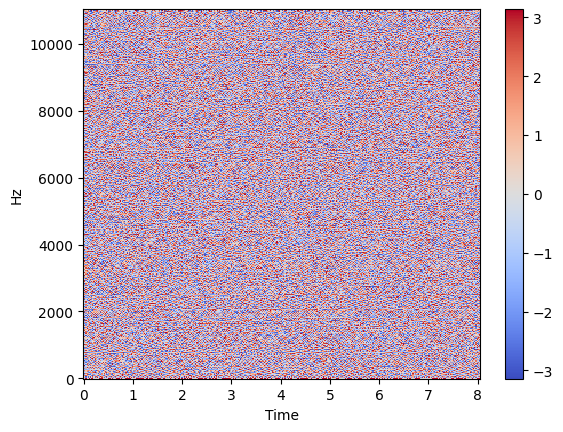

In [25]:
### compute phase spectrum
Y = np.angle(X)

fig = plt.figure()
img = librosa.display.specshow(Y, y_axis='linear', x_axis='time')
fig.colorbar(img)

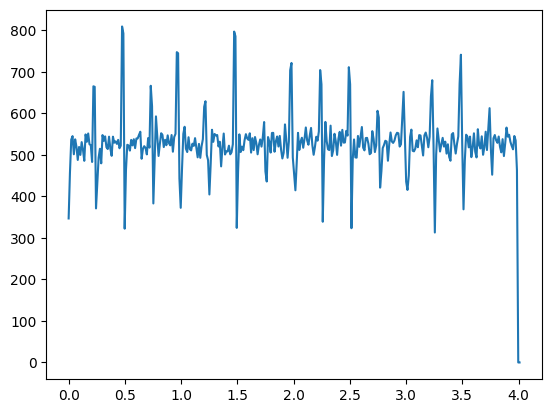

In [26]:
### compute temporal discrete second derivative
phase_diff = principal_argument(np.diff(Y, axis=1))
phase_diff2 = principal_argument(np.diff(phase_diff, axis=1))

novelty_phase = np.sum(np.abs(phase_diff2), axis=0)
novelty_phase = np.concatenate([novelty_phase, np.zeros(2)])

plt.plot(t_spec, novelty_phase)

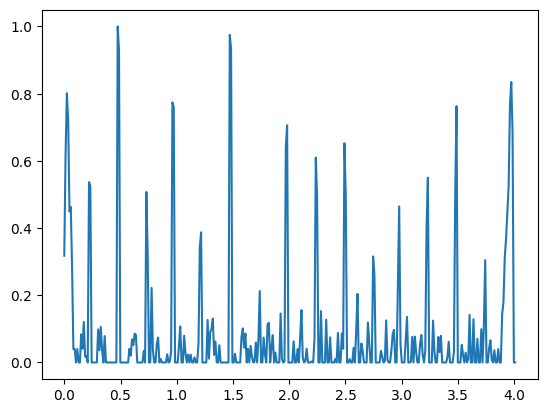

In [27]:
### apply normalization by subtracting local average
local_average = compute_local_average(novelty_phase, M)
novelty_phase = novelty_phase - local_average
novelty_phase[novelty_phase < 0] = 0
novelty_phase = novelty_phase / np.max(novelty_phase)

plt.plot(t_spec, novelty_phase)

# Tempogram

## Fourier Tempogram

In [28]:
### compute Fourier tempogram
fourier_tempogram = librosa.feature.fourier_tempogram(onset_envelope=novelty_energy, hop_length=N_h, sr=sr, window='hann')

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=384 is too large for input signal of length=347
  warnings.warn(


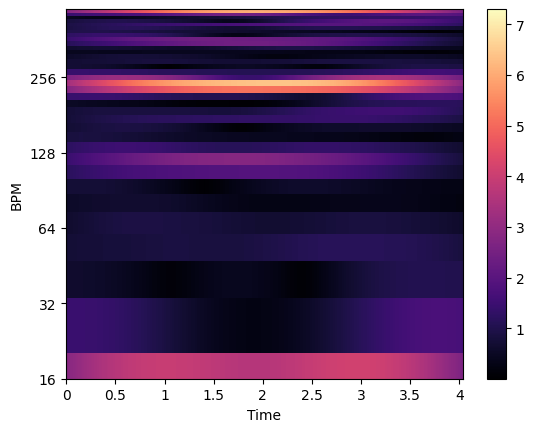

In [29]:
### plot Fourier tempogram
fig = plt.figure()
img = librosa.display.specshow(np.abs(fourier_tempogram), sr=sr, hop_length=N_h, y_axis='fourier_tempo', x_axis='time')
fig.colorbar(img)

## Autocorrelation Tempogram

In [30]:
### compute autocorrelation tempogram
ac_tempogram = librosa.feature.tempogram(onset_envelope=novelty_energy, sr=sr, hop_length=N_h, window='hann')

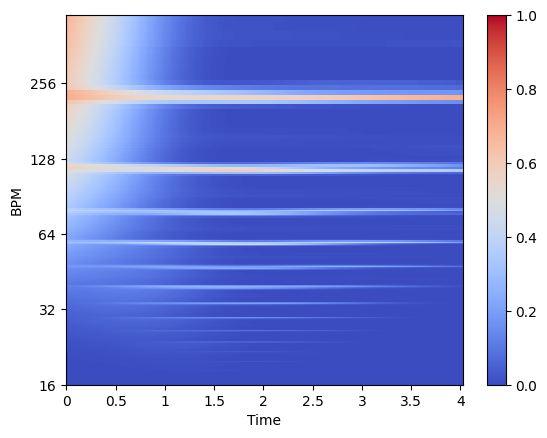

In [31]:
### plot autocorrelation tempogram
fig = plt.figure()
img = librosa.display.specshow(ac_tempogram, sr=sr, hop_length=N_h, y_axis='tempo', x_axis='time')
fig.colorbar(img)

# Beat Tracking

## Predominant Local Pulse

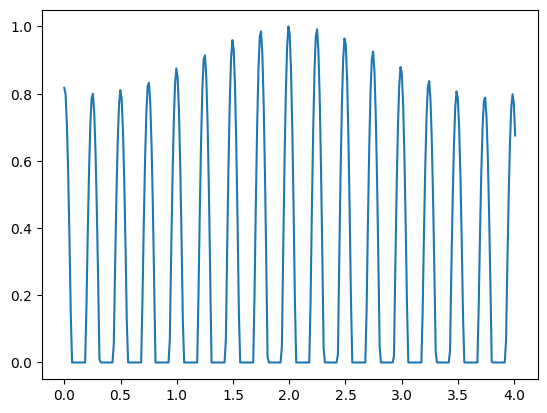

In [32]:
### compute PLP function
plp_pulse = librosa.beat.plp(onset_envelope=novelty_energy, sr=sr)

plt.plot(t_spec, plp_pulse)

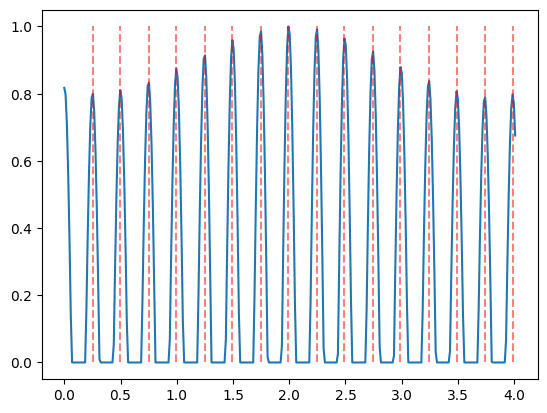

In [33]:
### find peaks to estimate beat positions
beat_plp = np.flatnonzero(librosa.util.localmax(plp_pulse))

plt.plot(t_spec, plp_pulse)
plt.vlines(t_spec[beat_plp], 0, 1, alpha=0.5, color='r', linestyle='--')

In [34]:
### synthesize pulse positions
clicks = librosa.clicks(times=t_spec[beat_plp], sr=sr, length=len(audio))

Audio(data=audio+clicks, rate=sr)